<a href="https://colab.research.google.com/github/nitish22066/PHYSICS-SOP-Gravitational-Lensing-/blob/main/GTOR_PROJECT_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strong Lensing Challenge - Regression


Task- To use regression to measure the total fraction of mass in substructure of a dark matter halo  utilizing simulated strong lensing images with subahlo substructure consistent with non-interacting cold dark matter models.

The task is to learn the total fraction of mass in substructure of a dark matter halo, i.e. $f_{sub} = m_{sub}/m_{halo}$ where $m_{sub}$ is the mass in substructure and $m_{halo}$ is the mass of the dark matter halo.

### Dataset

The dataset consists of *simulated* strong lensing images with cold dark matter subhalos generated by PyAutoLens. It contains 25k grayscale images with the size of 150x150 and the corresponding $f_{sub}$ which is known from simulations 

### Evaluation Metric

* MAE (Mean Absolute Error)





## Download Dataset

In [ ]:
!gdown http://drive.google.com/uc?id=1hu472ALwGPBcTCXSAM0VoCWmTktg9j-j


Downloading...
From: http://drive.google.com/uc?id=1hu472ALwGPBcTCXSAM0VoCWmTktg9j-j
To: /content/lens_data_alt.tgz
100% 573M/573M [00:03<00:00, 161MB/s]


In [ ]:
!tar zxvf lens_data_alt.tgz

Streaming output truncated to the last 5000 lines.
lens_data/image_129921264748304580224978784123993897887.npy
lens_data/image_60674821045913106252338146417083597669.npy
lens_data/image_7586588992730644946273072343065751609.npy
lens_data/image_256615804082514045226068245569293561600.npy
lens_data/image_331318447763555722421727000564541383144.npy
lens_data/image_306434472647715886273091851647655788036.npy
lens_data/image_153218353373199188551319913929375882134.npy
lens_data/image_11412000761836877732825972164665604473.npy
lens_data/image_266881034011026170985732508767754319849.npy
lens_data/image_322127030264560088986489885939769106814.npy
lens_data/image_103941636199723507484958618254099927151.npy
lens_data/image_182258691333363044109515573847422173318.npy
lens_data/image_317193050927123178027142767517329150638.npy
lens_data/image_7313831936673811745893506016093993651.npy
lens_data/image_123432310684084797411926937999919367992.npy
lens_data/image_234115468553431369454037687583967250944

In [ ]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

## Load Dataset

In [ ]:
DATASET_PATH = './lens_data'
images = []

f_subs = []
for f_name in os.listdir(DATASET_PATH):
  img, mass = np.load(os.path.join(DATASET_PATH,f_name),allow_pickle=True)

  images.append(img.reshape(1,img.shape[0],img.shape[1]))
 
  f_subs.append(np.array(mass,ndmin=1))


images = np.stack(images).astype('float32')

f_subs = np.stack(f_subs).astype('float32')


## Plot Strong Lensing Images(first 4 lenses)

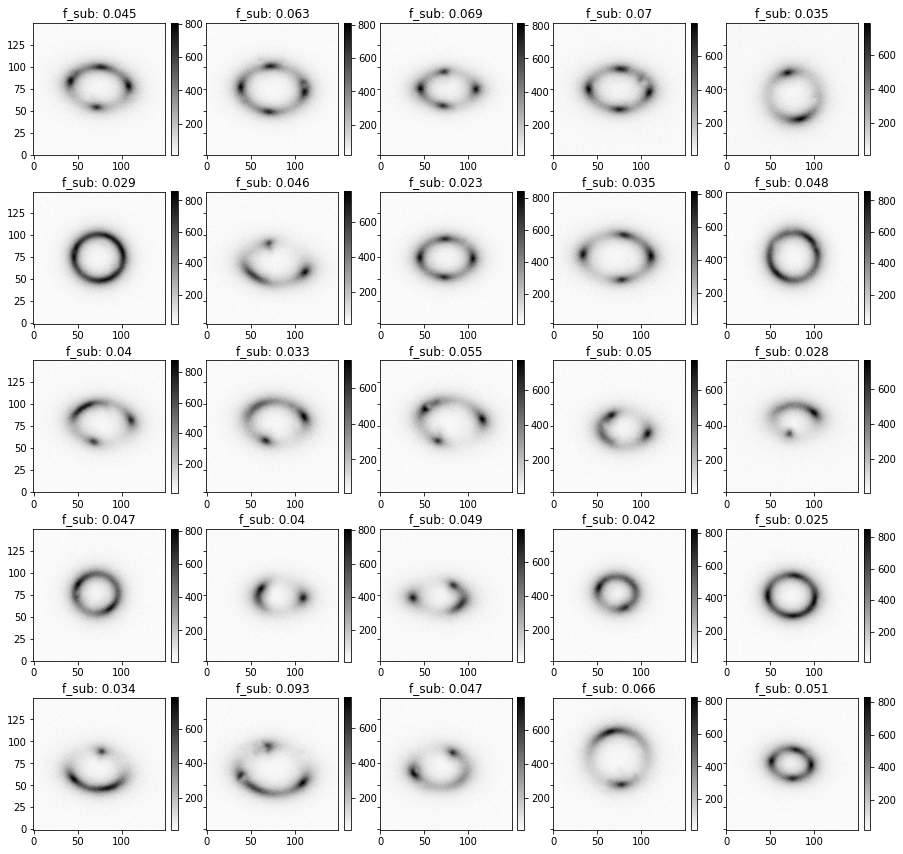

In [ ]:

grid_size = (5,5)
figure,axis = plt.subplots(grid_size[0],grid_size[1],figsize=(15,15),sharey=True)
img_indx=0

for i in range(grid_size[0]):
  for j in range(grid_size[1]):
    img = axis[i][j].imshow(images[img_indx][0], cmap='binary', origin='lower')
    axis[i][j].set_title(f'f_sub: {f_subs[img_indx][0]:.2}')
    plt.colorbar(img,ax=axis[i][j],fraction=0.046, pad=0.04)

    img_indx+=1
plt.show()

## Standardization


In [ ]:

def standardize(element,STD,MEAN):
    return (element - MEAN) / STD
def inv_standardize(element,STD,MEAN):
    return element * STD + MEAN

IMAGES_MEAN, IMAGES_STD = images.mean(), images.std()
F_SUB_MEAN, F_SUB_STD = f_subs.mean(), f_subs.std()


images=standardize(images,IMAGES_STD,IMAGES_MEAN)
f_subs=standardize(f_subs,F_SUB_STD,F_SUB_MEAN)

## Create Custom Dataset

In [ ]:
class RegressionNumpyArrayDataset(Dataset):
  def __init__(self,x,y,indexes=None,x_transforms_func = None):

    self.x = x[indexes]
    self.y = y[indexes]

    self.x_transforms = x_transforms_func


  def __len__(self):
 
    return self.x.shape[0]

  def __getitem__(self, idx):

    image, label = self.x[idx], self.y[idx]

    image = torch.tensor(image).float()
    label = torch.tensor(label).float()

    if self.x_transforms!=None:
      image= self.x_transforms(image)


    return  image , label 

## Split Dataset

In [ ]:
train_indx = np.arange(0,15000)#np.arange(0,13000)
test_indx = np.arange(15000,20000)

## Image Augmentation

In [ ]:
base_image_transforms = transforms.Compose([
    transforms.Resize(150)
])

In [ ]:

train_dataset = RegressionNumpyArrayDataset(images, f_subs, train_indx,
                                            base_image_transforms)
test_dataset = RegressionNumpyArrayDataset(images, f_subs, test_indx,                                 
                                           base_image_transforms)

batch_size = 64

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Regression Models

In [ ]:
class LinearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
    
        flatten_x = torch.flatten(x,start_dim=1)
        out = self.linear(flatten_x)
        return out

class Resnet18Regression(torch.nn.Module):
    def __init__(self, num_of_input_channels, output_size):
        super(Resnet18Regression, self).__init__()
        self.resnet18 = torchvision.models.resnet18()

        self.resnet18.conv1 = torch.nn.Conv2d(num_of_input_channels, 64, kernel_size=(7, 7), 
                                 stride=(2, 2), padding=(3, 3), bias=False)

        self.resnet18.fc = torch.nn.Linear(in_features=512, out_features=output_size, 
                                           bias=True)

    def forward(self, x):
        out = self.resnet18(x)
        return out

## Loss Function

In [ ]:
def mse_loss(pred, true):
    loss = (pred-true).pow(2)
    return loss.mean()

## Training

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')


model = Resnet18Regression(1,1).to(device)

Device: cuda


In [ ]:

lr = 3e-4
weight_decay = 0
num_of_epochs = 40

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:

for i in range(num_of_epochs):
  epoch_loss = 0
  num_of_steps_in_epoch = 0
  for step, (images_batch, f_subs_batch) in enumerate(train_data_loader):
    optimizer.zero_grad()


    if torch.cuda.is_available():
      images_batch = images_batch.cuda()
      f_subs_batch = f_subs_batch.cuda()


    predicted_f_subs = model(images_batch)
    

    loss = mse_loss(predicted_f_subs,f_subs_batch)


    loss.backward()
  
    optimizer.step()

    
    epoch_loss+=loss
    num_of_steps_in_epoch+=1
  
  loss_w = (epoch_loss/num_of_steps_in_epoch).detach().item()
  print(f'Epoch {i+1} loss is: {loss_w}')
  

Epoch 1 loss is: 1.0516858100891113
Epoch 2 loss is: 1.0182684659957886
Epoch 3 loss is: 1.0088040828704834
Epoch 4 loss is: 1.00783109664917
Epoch 5 loss is: 0.9983000755310059
Epoch 6 loss is: 0.9925909638404846
Epoch 7 loss is: 0.9562601447105408
Epoch 8 loss is: 0.8941338062286377


## Testing

In [ ]:

predicted_f_subs_list = []
real_f_subs_list = []
for step, (images, f_subs) in enumerate(test_data_loader):

    if torch.cuda.is_available():
      images = images.cuda()
      f_subs = f_subs.cuda()

    predicted_f_subs = model(images)
    predicted_f_subs_list.append(predicted_f_subs.cpu().detach().numpy())
    real_f_subs_list.append(f_subs.cpu().numpy())


del predicted_f_subs_list[-1]
del real_f_subs_list[-1]

In [ ]:

def mae_loss(pred, true):
    loss = np.abs(pred-true)
    return loss.mean()

## Plot the results

In [ ]:

predicted_f_subs_arr = np.concatenate(predicted_f_subs_list)
real_f_subs_arr = np.concatenate(real_f_subs_list)

m_pred,m_true = inv_standardize(predicted_f_subs_arr,F_SUB_STD,F_SUB_MEAN),inv_standardize(real_f_subs_arr,F_SUB_STD,F_SUB_MEAN)



test_mae = mae_loss(m_pred,m_true)
plt.figure(figsize=(8,8),dpi=80)
plt.scatter(m_true, m_pred,  color='black')
line = np.linspace(0, 0.3, 10)
plt.plot(line, line)
plt.xlabel('Observed mass fraction')
plt.ylabel('Predicted mass fraction')
print(f'MAE: {test_mae}')
#plt.text(1,4, 'MAE: {:.4f}'.format(test_mae))



## Save the model

In [ ]:
SAVE_PATH = './best_model'
torch.save(model.state_dict(), SAVE_PATH)

## Submission Guidelines 

* You are required to submit a Google Colab Jupyter Notebook clearly showing your implementation along with the evaluation metrics (MAE) for the training and validation data.
* You also have to submit the final trained model, including the model architecture and the trained weights ( For example: HDF5 file, .pb file, .pt file, etc. )
* You can use this example notebook as a template for your work.
+ The model performance will be evaluated on the hidden dataset based on the above metrics. 

> **_NOTE:_**  You are free to use any ML framework such as PyTorch, Keras, TensorFlow, etc.